<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# **Project 3:** Subreddit Text Classification

## Purpose

The primary goal of this project is to build a text classification model that can accurately predict which of two subreddits a given post belongs to. This capability is to help researchers by automating the category of content, improving effiency.

## Table of Contents

1. [Exective Summary](#exective-summary)
   
1. [Problem Statement](#problem-statement)

1. [Data](#data)

1. [Interpretation/Summary](#interpretation/summary)

---
## Exective Summary

This project will focus on developing a classsification model to classify posts between two subreddits: dogs_subreddit and personalfinance_subreddit. Using logistic regression and the random forest model, the project will demonstrate how supervised learning can be utilized to address the challenge categorization within a large platform.

---
## Problem Statement

Reddit is comprised of numerous communities known as subreddits, where each subreddit is tailored to a specific interest, and misclassified posts can disrupt community discussions and reduce user engagement. To address this; I have taliored this project to develop and evaluate two supervised learning models:

| Model Type                 | Model Description                                           |  
|------------------------|-------------------------------------------------------|  
| Logistic Regression    | A baseline model offering simplicity and interpretability. |  
| Random Forest          | A model capturing non-linear relationships for better accuracy. |

The success of the model is measured by evaluating accuracy, precision, recall, and F1-score on the test dataset. By streamlining subreddit classification, this project directly benefits researchers studying community behavior.

---

## Data Overview

There is 4 datasets included in the ['p3_data'](''./p3_data') folder for this project. I picked one which combined all my datasets but are cleaned and balanced out.

* [`final_df.csv`](./p3_data/final_df.csv): Subreddit post combined into 1 with the data already cleaned.

Source: Posts were collected using the Reddit API from two subreddits: dogs_subreddit and personalfinance_subreddit.

- Vocab: 
1. Lemmatization is a text preprocessing technique in natural language processing (NLP) that reduces words to their base or dictionary form, called a lemma. Unlike stemming, which often chops off word endings to create a simpler form, lemmatization considers the context and grammar of the word to ensure the base form is valid in a language.

1. stop_words - are common words in a language that are typically filtered out during natural language processing (NLP) tasks. These words are often removed because they occur frequently in text but usually do not carry meaningful information for tasks like classification, clustering, or topic modeling.

---

### Part 1. Data Set Up
- Import The Libraries Required To Begin Working Towards The Problem Statement
- Initialize PRAW and Authenicate Reddit API
- Assign a varable to the subreddit we are comparing.
- Show the function that was used to call in the number of post. **(1000 min post)**
- Read-In the complete data **(Should've been collected and stored during data collection)**

In [1]:
#Imports
import praw
import os
#Needed to read in the varibles that are sensitive.
from dotenv import load_dotenv
load_dotenv()

import numpy as np
import pandas as pd

#I hid my sensitve information in an environment variable file
#dotenv is to protect my information like my client_id, client_secret, and password; that was stored in my .env folder

In [2]:
#Initialize PRAW and Authenticate API
reddit = praw.Reddit(
    client_id = os.getenv('client_id'),
    client_secret = os.getenv('client_secret'),
    user_agent = 'text_classifier:v1.0 (by DvisionaryS)',
    username = 'DvisionaryS',
    password = os.getenv('password')
)

In [3]:
# Assign a variable to the subreddits of your choosing
subreddit_1 = 'dogs'
subreddit_2 = 'personalfinance'

In [4]:
# Function to find post for the dataset where n: represents the number of post we are trying to pull in.
def fetch_posts(subreddit_name, total_posts=5000, batch_size=1000):
    subreddit = reddit.subreddit(subreddit_name)  # Access the subreddit
    posts = []
    after = None  # Placeholder for pagination
    fetched_post_ids = set()  # Set to track already fetched post IDs
    loops = total_posts // batch_size  # Number of loops required, adjusted to total posts

    print(f"Fetching posts from subreddit: {subreddit_name}")

    for i in range(loops):
        if i % 10 == 0: 
            print(f"Starting loop {i + 1}/{loops}")  # Print progress every 10 loops

        try:
            # Fetch posts in batches
            batch_posts = subreddit.new(limit=batch_size)
            for post in batch_posts:
                if post is not None:
                    # Skip posts that have already been fetched
                    if post.id not in fetched_post_ids:
                        posts.append({
                            'subreddit': post.subreddit.display_name,  # Export the titles I am interested in
                            'title': post.title,
                            'selftext': post.selftext,
                            'utc': post.created_utc
                        })
                        fetched_post_ids.add(post.id)  # Mark this post as fetched

            # Simulate delay to avoid rate limits
            time.sleep(60)

        except Exception as e:
            print(f"Error occurred: {e}")
            break

    return pd.DataFrame(posts)

#### Run fetch_post(subreddit_variable)(**From the variable we assigned**) 
- Store the function as a varible so the collected data is availiable for viewing.

##### EX: 
- sub_1 = fetch_posts(subreddit_1) 
- sub_2 = fetch_posts(subreddit_2)

In [5]:
#Read in the  data
df = pd.read_csv('./p3_data/final_df.csv')

### Part 2: Exploratory Data Analysis (EDA)
- View the data (View the first few rows, and see how much data is in your dataset) **(Hint: .head(), .shape, .info(), .describe())**
- Check the data for duplicates and missing data.
- Text length and word count analysis.
- Distribution of each subreddit.
- Top individual words and bigrams for each subreddit.
- Correlation matrix for numerical features.
- Box plots for post scores and average word lengths
- Analysis of text complexity through average word length.
- Bigrams to understand common word pairings.

| Value | Subreddit              |
|-------|------------------------|
| 1     | dogs_subreddit         |
| 0     | personalfinance_subreddit |

In [6]:
#Import Libraries
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

In [7]:
#View the dataset
df.shape

(2004, 4)

In [8]:
#Overview of data
df.head()

,title,selftext,subreddit,utc
0,"Living overseas, investing in the US...worried...","Hi everyone, I'm living overseas at the moment...",0,1.731653e+09
1,"[Weekly Vent]September 30-04, 2024",Is someone not picking up poop in front of you...,1,1.727698e+09
2,Choosing My First Dog: Shih Tzu vs. Bichon Fri...,"Hello, r/dogs community! I’m on the verge of b...",1,1.731888e+09
3,Early withdrawal after termination with outsta...,I’m going to go over what I think I know. I’m ...,0,1.732383e+09
4,Megathread: Why Does My Dog Do That?,Does your dog turn his head when he hears an o...,1,1.727539e+09


In [9]:
#View the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      2004 non-null   object 
 1   selftext   2004 non-null   object 
 2   subreddit  2004 non-null   int64  
 3   utc        2004 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 62.8+ KB


In [10]:
#Statical view of the data
df.describe()

,subreddit,utc
count,2004.000000,2.004000e+03
mean,0.500000,1.730681e+09
std,0.500125,1.836978e+06
min,0.000000,1.726435e+09
25%,0.000000,1.729269e+09
50%,0.500000,1.731689e+09
75%,1.000000,1.732124e+09
max,1.000000,1.732494e+09


In [11]:
#Check for null values
df.isnull().sum()

title        0
selftext     0
subreddit    0
utc          0
dtype: int64

In [12]:
#Add a column for text
df['text'] = df['title'] + " " +df['selftext']

In [13]:
#Create a column for text_length
df['text_length'] = df['text'].apply(len)

In [14]:
#Create a column for the word_count
df['word_count'] = df['text'].apply(lambda x: len(word_tokenize(x)))

In [15]:
#Check the distribution of data
df['subreddit'].value_counts()

subreddit
0    1002
1    1002
Name: count, dtype: int64

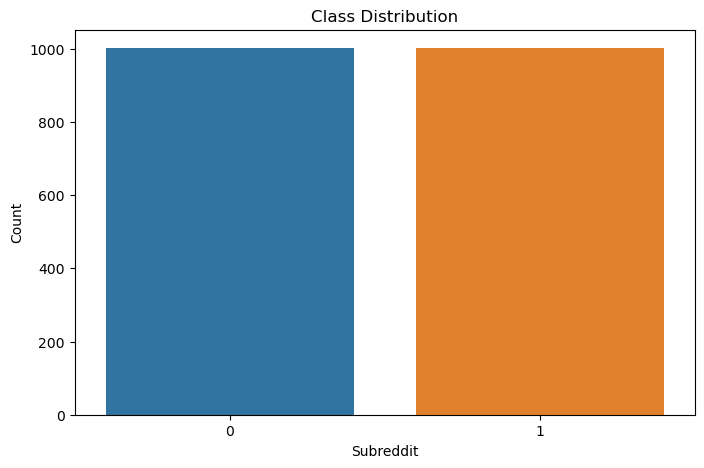

In [16]:
# Visual of distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='subreddit', hue='subreddit', palette=['#1f77b4', '#ff7f0e'], legend=False)
plt.title('Class Distribution')
plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.show();

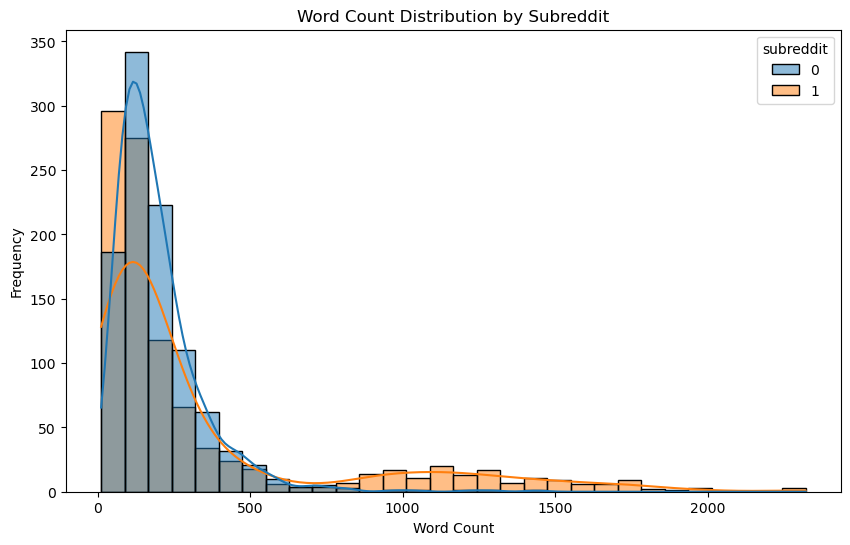

In [17]:
#Word count distributions 
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='subreddit', kde=True, bins=30)
plt.title('Word Count Distribution by Subreddit')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [18]:
#Top words for each subreddit
def get_top_words(texts, top_n=20):
    all_words = " ".join(texts).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

for subreddit in df['subreddit'].unique():
    subreddit_texts = df[df['subreddit'] == subreddit]['text']
    top_words = get_top_words(subreddit_texts, top_n=10)
    print(f"\nTop Words in {subreddit} Subreddit:")
    for word, count in top_words:
        print(f"{word}: {count}")


Top Words in 0 Subreddit:
I: 6261
to: 5332
the: 4506
a: 4498
and: 4010
my: 2919
in: 2534
for: 2208
of: 2188
have: 1746

Top Words in 1 Subreddit:
to: 9642
a: 7551
and: 7126
the: 6482
I: 5760
dog: 5309
you: 4858
of: 3658
in: 3364
with: 3239


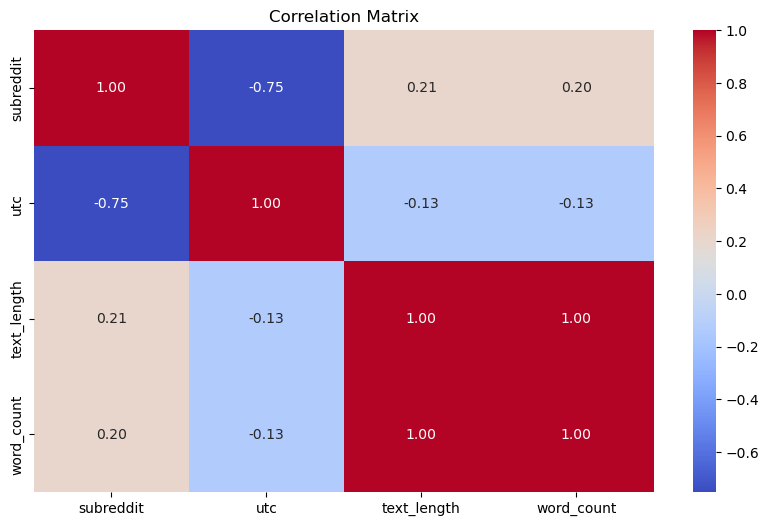

In [19]:
#Correlation analysis
numeric_features = df.select_dtypes(include=np.number)
if not numeric_features.empty:
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show();

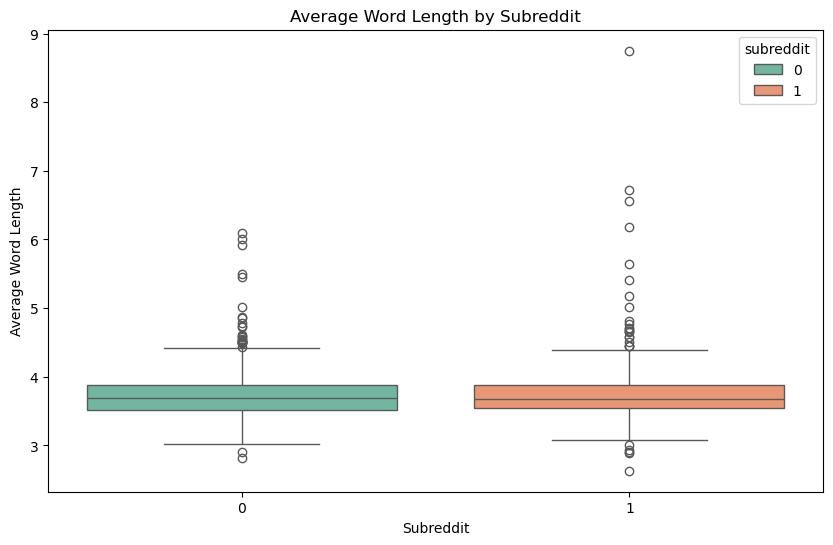

In [20]:
#Token length analysis
df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]))
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='subreddit', y='avg_word_length', hue='subreddit', palette='Set2')
plt.title('Average Word Length by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Word Length')
plt.show()

/var/folders/pk/z58dkjgn50153_74d2055v0r0000gn/T/ipykernel_26674/1887932637.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=bigrams, palette="coolwarm")


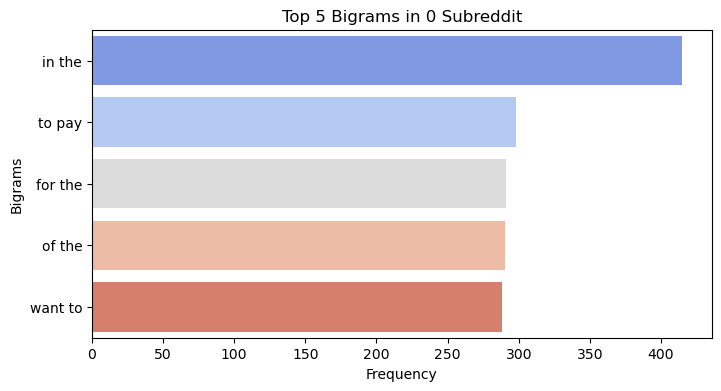

/var/folders/pk/z58dkjgn50153_74d2055v0r0000gn/T/ipykernel_26674/1887932637.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=bigrams, palette="coolwarm")


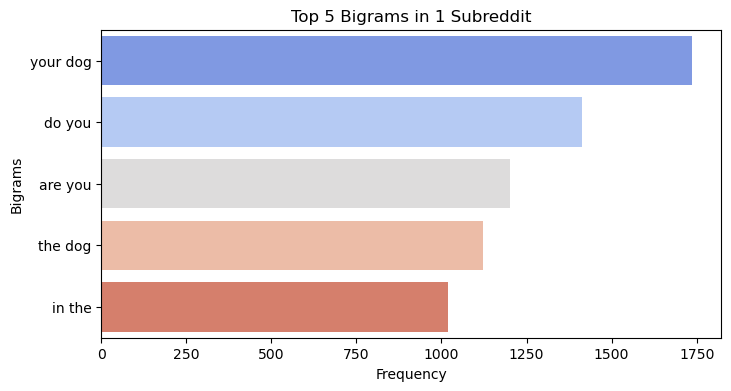

In [21]:
#Extracts top n_grams
def get_top_ngrams(corpus, n=2, top_n=5):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(corpus)
    sum_ngrams = ngrams.sum(axis=0)
    ngram_counts = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return sorted(ngram_counts, key=lambda x: x[1], reverse=True)[:top_n]

#Plots the top n_grams
def plot_top_bigrams(subreddit, bigrams, top_n=5):
    bigrams, counts = zip(*bigrams)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=counts, y=bigrams, palette="coolwarm")
    plt.title(f"Top {top_n} Bigrams in {subreddit} Subreddit")
    plt.xlabel("Frequency")
    plt.ylabel("Bigrams")
    plt.show()
#Compares the subreddits in seperate charts
def compare_bigrams_separately(df, subreddit_col, text_col, n=2, top_n=5):
    subreddits = df[subreddit_col].unique()
    
    for subreddit in subreddits:
        subreddit_corpus = df[df[subreddit_col] == subreddit][text_col]
        top_bigrams = get_top_ngrams(subreddit_corpus, n=n, top_n=top_n)
        plot_top_bigrams(subreddit, top_bigrams, top_n=top_n)

# Example Usage
compare_bigrams_separately(df, subreddit_col='subreddit', text_col='text', n=2, top_n=5)

#### Based on the data avaliable; I believe that I will be able to address my problem statement of can I effectively build a model and based on the data that is given: can it determine which subreddit it belongs to belongs to with high accuracy.

### Part 3: Data Preprocessing(Natural Language Preprocessing)(NLP)
- Tokenization, lemmatization, and stopword removal.
- Encode the text. (Done in the data collection)

In [22]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

In [23]:
# Define preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#Preprocess new data
def preprocess(text):
     # Lowercase and remove non-alphabetic characters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
        tokens = text.split()
    # Tokenize and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
        return " ".join(tokens)


In [24]:
#Apply preprocessing
df['text'] = (df['text'].apply(preprocess))

### Part 4: Model Building
- Split the data into training and test sets
- Train a classification model
- Vectorize the text.
- Evaluate model performance using metrics such as accuracy

### Classification Accuracy Score

The formula for classification accuracy is:
## Accuracy = $\frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}$


| Value | Subreddit              |
|-------|------------------------|
| 1     | dogs_subreddit         |
| 0     | personalfinance_subreddit |

In [25]:
#Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [26]:
#Baseline accuracy
baseline = df['subreddit'].value_counts(normalize=True).max()
print(f'Baseline Accuracy: {baseline:.2f}')

Baseline Accuracy: 0.50


In [27]:
#Set target variable
X = df['text']
y = df['subreddit'] 

In [28]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [29]:
# Simulate random guessing
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train, y_train)
baseline_score = dummy.score(X_test, y_test)
print(f'Baseline Accuracy (Random Guessing): {baseline_score:.2%}')

Baseline Accuracy (Random Guessing): 50.66%


In [30]:
#Vectorize the text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [31]:
#Identify the two models
#Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train_vect, y_train)
pred_lr = model_lr.predict(X_test_vect)

#Random Forest
model_rf = RandomForestClassifier(n_estimators=100,
                                  max_depth=4,
                                  min_samples_split=200,
                                  random_state=42)
model_rf.fit(X_train_vect, y_train)
pred_rf = model_rf.predict(X_test_vect)

In [32]:
#Logistics Regression accuracy
lr_accuracy = model_lr.score(X_test_vect, y_test)
print(f'Logistics Regression Accuracy: {lr_accuracy:.2%}')

Logistics Regression Accuracy: 99.83%


In [33]:
#View classification report
classifi = classification_report(y_test, pred_lr)
print(f'Log Regression Classification Report:\n {classifi}')

Log Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00       301

    accuracy                           1.00       602
   macro avg       1.00      1.00      1.00       602
weighted avg       1.00      1.00      1.00       602



In [34]:
#Random Forest accuracy
rf_accuracy = model_rf.score(X_test_vect, y_test)
print(f'Random Forest Accuracy: {rf_accuracy:.2%}')

Random Forest Accuracy: 98.01%


In [35]:
#View classification report
classi = classification_report(y_test, pred_rf)
print(f'Random Forest Classification Report:\n {classi}')

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       301
           1       1.00      0.96      0.98       301

    accuracy                           0.98       602
   macro avg       0.98      0.98      0.98       602
weighted avg       0.98      0.98      0.98       602



### Part 5: Test Model on completely new data
- Use fetch model(from [Part 1](Part_1._Data_Set_Up)) for subreddits
- Fetch new data
- Preprocess the data
- Vectorize the data
- Use the model to predict the subreddit
- View the accuracy

In [36]:
#Import the required library
from sklearn.metrics import confusion_matrix

In [37]:
#Run the code fetch_post(subreddit name)
#import time
sub_1 = fetch_posts(subreddit_1)
sub_2 = fetch_posts(subreddit_2)

Fetching posts from subreddit: dogs
Starting loop 1/5
Error occurred: name 'time' is not defined
Fetching posts from subreddit: personalfinance
Starting loop 1/5
Error occurred: name 'time' is not defined


In [38]:
sub_1.head()

,subreddit,title,selftext,utc
0,dogs,How do you know that your male puppy is nearin...,"Long story short, I have a 9,5 months old fema...",1.737830e+09
1,dogs,Pacemaker,Has anyone had success with pacemaker for thei...,1.737830e+09
2,dogs,Labrador hairloss is abnormal?,Would love some feedback about a recent sheddi...,1.737826e+09
3,dogs,Megathread: Pet Insurance,Which pet insurance is best for you? Are there...,1.737825e+09
4,dogs,Megathread: Why Does My Dog Do That?,Does your dog turn his head when he hears an o...,1.737824e+09


In [39]:
sub_1.shape

(975, 4)

In [40]:
sub_2.head()

,subreddit,title,selftext,utc
0,personalfinance,Can I retire at this age,32M. Planning to retire at 50 once kids are mo...,1.737831e+09
1,personalfinance,How to improve my credit score?,I have a capital one credit card with a credit...,1.737831e+09
2,personalfinance,Back door Roth IRA initial steps,Been trying to figure out the back door Roth s...,1.737831e+09
3,personalfinance,Why aren't my IRA contributions tax deductable?!?,I make about 160k and I have a 401k. I contrib...,1.737831e+09
4,personalfinance,"What to do with $30,000 for three years?",Soon I will be receiving a bonus from work. Af...,1.737831e+09


In [41]:
sub_2.shape

(986, 4)

In [42]:
# Assign labels for the subreddit column
sub_1['subreddit'] = 1 #Label 'dogs' as 1
sub_2['subreddit'] = 0 #Label 'personalfinance' as 0

In [43]:
sub_1.head()

,subreddit,title,selftext,utc
0,1,How do you know that your male puppy is nearin...,"Long story short, I have a 9,5 months old fema...",1.737830e+09
1,1,Pacemaker,Has anyone had success with pacemaker for thei...,1.737830e+09
2,1,Labrador hairloss is abnormal?,Would love some feedback about a recent sheddi...,1.737826e+09
3,1,Megathread: Pet Insurance,Which pet insurance is best for you? Are there...,1.737825e+09
4,1,Megathread: Why Does My Dog Do That?,Does your dog turn his head when he hears an o...,1.737824e+09


In [44]:
test_df = pd.concat([sub_1, sub_2], ignore_index=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [45]:
test_df['text'] = test_df['title'] + ' ' + test_df['selftext']

In [46]:
test_df['text'] = (test_df['text'].apply(preprocess))

In [47]:
#Vectorize the text for model entry
new_df_vect = vectorizer.transform(test_df['text'])

In [48]:
#Test the data on unseen data
lr_model_test = model_lr.predict(new_df_vect)
rf_model_test = model_rf.predict(new_df_vect)

In [49]:
#Create a column to see what the actual subreddit was vs the preditcions of my models
test_df['logreg_predz'] = lr_model_test
test_df['rf_predz'] = rf_model_test

In [50]:
test_df.head()

,subreddit,title,selftext,utc,text,logreg_predz,rf_predz
0,0,Former poor kid needing advice,I'm in line for a job that could take me from ...,1.737770e+09,former poor kid needing advice line job could ...,0,0
1,1,Smelly high value treats that don’t contain po...,Hi all! I’m hoping you can help me come up wit...,1.736639e+09,smelly high value treat contain poultry hi hop...,1,1
2,1,Mental activity for dogs when home alone?,What does your dog do when they’re alone? Any ...,1.736860e+09,mental activity dog home alone dog alone fun p...,1,1
3,1,How heavy should the owner be compared to the ...,I don’t think I’ve seen this topic be discuss...,1.736969e+09,heavy owner compared dog think seen topic disc...,1,1
4,0,What should I do with my relocation bonus?,I’m 21 and just got a new job and moved to a n...,1.737637e+09,relocation bonus got new job moved new city go...,0,0


In [51]:
#Eval the LogisticRegression model based on accuracy for the new data it saw
prediction = model_lr.predict(new_df_vect)
accu = accuracy_score(test_df['subreddit'], prediction)
print(f'Logistics Regression Accuracy on Imported Data: {accu:.2%}')

Logistics Regression Accuracy on Imported Data: 99.85%


In [52]:
#Eval the RandomForest model based on accuracy for the new data it saw
predictionz = model_rf.predict(new_df_vect)
acc = accuracy_score(test_df['subreddit'], predictionz)
print(f'Random Forest Accuracy on Imported Data: {acc:.2%}')

Random Forest Accuracy on Imported Data: 96.58%


### Confusion Matrix
- Give the predictions a variable
- Assign the ConfusionMatrix a variable
- Re-Introduce the key for the binary classifications in the data
- Plot the ConfusionMatrix

In [53]:
#Give the predictions a variable
log_reg_pred = model_lr.predict(X_test_vect)
rf_pred = model_rf.predict(X_test_vect)

In [54]:
#Assign a variable to the ConfusionMatrix
log_cm = confusion_matrix(y_test, log_reg_pred)
rf_cm = confusion_matrix(y_test, rf_pred)

#### Re-introduce what each binary value represents

| Value | Subreddit              |
|-------|------------------------|
| 1     | dogs_subreddit         |
| 0     | personalfinance_subreddit |

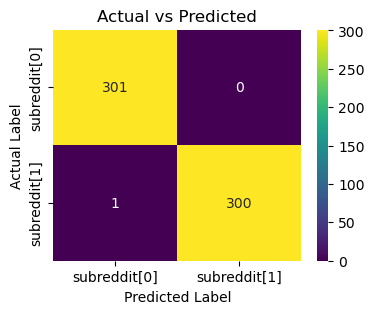

In [55]:
#Plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['subreddit[0]' , 'subreddit[1]'], yticklabels=['subreddit[0]' , 'subreddit[1]'])
    plt.title('Actual vs Predicted')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

#Matrix for LogisticRegression Model
plot_confusion_matrix(log_cm, 'Logistic Regression CM') 


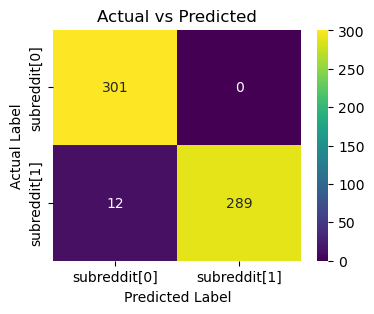

In [56]:
#Matrix for RandomForest Model
plot_confusion_matrix(rf_cm, 'Random Forest CM')

### Conclusion & Recommendation
- Reintroduce the problem statement
- Identify If we were able to complete the problem statement
- Give suggestions on which model I would recommend if they are suitble for production

Was I able to answer my problem statement?
- Yes; I was successfully able to create a high performing model that was able to take in new data and predict the out come on a very high level. Below you can see a visula represntation of how both of my created models performed on a set of data that I split and on data that I pulled in. (You can rerun this notebook and the tested data that is pulled in will always change and the scores remain high well into the 96% and higher)

| Dataset                 | Logistic Regression | Random Forest |
|-------------------------|---------------------|---------------|
| Test Set Accuracy       | LG Accuracy 99.83%               | RF Accuracy 98.01%          |
| Unseen Test Set Accuracy       | LG Accuracy ~99%               | RF Accuracy ~96%          |

The model I would advice to be utilized is the Logistic Regression model because the task is simple and since it is a classification model you can train any two subreddits to filter into the proper channel with the model.